In [1]:
import dotenv
dotenv.load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')


In [2]:
from newsapi import NewsApiClient
import os
newsapi_key = os.getenv("NEWSAPI_KEY")
if newsapi_key:
        print("NEWSAPI_KEY successfully loaded from .env.")

NEWSAPI_KEY successfully loaded from .env.


In [3]:
llm.invoke("Why is the sky blue?").content


"The sky appears blue primarily due to a phenomenon called Rayleigh scattering. This occurs when sunlight interacts with the molecules and small particles in the Earth's atmosphere.\n\nSunlight, or white light, is made up of different colors, each with varying wavelengths. Blue light has a shorter wavelength compared to other colors, such as red or yellow. When sunlight passes through the atmosphere, the shorter wavelengths of light (blue and violet) are scattered in all directions by the gases and particles in the air.\n\nAlthough violet light is scattered even more than blue light, our eyes are more sensitive to blue light, and some of the violet light is absorbed by the ozone layer. As a result, we perceive the sky as blue during the day.\n\nAt sunrise and sunset, the sun's light has to pass through more of the Earth's atmosphere, which scatters the shorter wavelengths out of the line of sight. This leaves the longer wavelengths, like red and orange, which is why the sky can appear 

In [6]:
newsapi = NewsApiClient(api_key=os.getenv('NEWSAPI_KEY'))

query = 'ai news of the day'

all_articles = newsapi.get_everything(q=query,
                                      sources='google-news,bbc-news,techcrunch',
                                      domains='techcrunch.com, bbc.co.uk',
                                      language='en',
                                      sort_by='relevancy',
                                      )


all_articles['articles'][-1]

{'source': {'id': 'techcrunch', 'name': 'TechCrunch'},
 'author': 'Margaux Maccoll',
 'title': 'From recruiting for Palantir to landing a plane on Highway 85: meet defense tech’s wildest power broker | TechCrunch',
 'description': 'Peter Conway has recruited for some of the buzziest defense and hard tech firms in Silicon Valley over the last decade, like Palantir and Mach Industries.',
 'url': 'https://techcrunch.com/2025/01/19/from-recruiting-for-palantir-to-landing-on-highway-85-meet-defense-techs-wildest-power-broker/',
 'urlToImage': 'https://techcrunch.com/wp-content/uploads/2025/01/IMG_0868.jpg?resize=1200,798',
 'publishedAt': '2025-01-19T21:03:21Z',
 'content': 'In 2023, defense tech recruiter Peterson ConwayVIII pulled up to the offices of nuclear fusion startup Fuse in a black Suburban, donning his signature cowboy hat. He picked up a recent Fuse hire and … [+10991 chars]'}

In [7]:
from typing import TypedDict, Annotated, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from datetime import datetime
import re
class GraphState(TypedDict):
    news_query: Annotated[str, "Input query to extract news search parameters from."]
    num_searches_remaining: Annotated[int, "Number of articles to search for."]
    newsapi_params: Annotated[dict, "Structured argument for the News API."]
    past_searches: Annotated[List[dict], "List of search params already used."]
    articles_metadata: Annotated[list[dict], "Article metadata response from the News API"]
    scraped_urls: Annotated[List[str], "List of urls already scraped."]
    num_articles_tldr: Annotated[int, "Number of articles to create TL;DR for."]
    potential_articles: Annotated[List[dict[str, str, str]], "Article with full text to consider summarizing."]
    tldr_articles: Annotated[List[dict[str, str, str]], "Selected article TL;DRs."]
    formatted_results: Annotated[str, "Formatted results to display."]

In [8]:
class NewsApiParams(BaseModel):
    q: str = Field(description="1-3 concise keyword search terms that are not too specific")
    sources: str =Field(description="comma-separated list of sources from: 'abc-news,abc-news-au,associated-press,australian-financial-review,axios,bbc-news,bbc-sport,bloomberg,business-insider,cbc-news,cbs-news,cnn,financial-post,fortune'")
    from_param: str = Field(description="date in format 'YYYY-MM-DD' Two days ago minimum. Extend up to 30 days on second and subsequent requests.")
    to: str = Field(description="date in format 'YYYY-MM-DD' today's date unless specified")
    language: str = Field(description="language of articles 'en' unless specified one of ['ar', 'de', 'en', 'es', 'fr', 'he', 'it', 'nl', 'no', 'pt', 'ru', 'se', 'ud', 'zh']")
    sort_by: str = Field(description="sort by 'relevancy', 'popularity', or 'publishedAt'")

In [9]:
def generate_newsapi_params(state: GraphState) -> GraphState:
    """Based on the query, generate News API params."""
    # initialize parser to define the structure of the response
    parser = JsonOutputParser(pydantic_object=NewsApiParams)

    # retrieve today's date
    today_date = datetime.now().strftime("%Y-%m-%d")

    # retrieve list of past search params
    past_searches = state["past_searches"]

    # retrieve number of searches remaining
    num_searches_remaining = state["num_searches_remaining"]

    # retrieve the user's query
    news_query = state["news_query"]

    template = """
    Today is {today_date}.

    Create a param dict for the News API based on the user query:
    {query}

    These searches have already been made. Loosen the search terms to get more results.
    {past_searches}
    
    Following these formatting instructions:
    {format_instructions}

    Including this one, you have {num_searches_remaining} searches remaining.
    If this is your last search, use all news sources and a 30 days search range.
    """

    # create a prompt template to merge the query, today's date, and the format instructions
    prompt_template = PromptTemplate(
        template=template,
        variables={"today": today_date, "query": news_query, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining},
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    # create prompt chain template
    chain = prompt_template | llm | parser

    # invoke the chain with the news api query
    result = chain.invoke({"query": news_query, "today_date": today_date, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining})

    # update the state
    state["newsapi_params"] = result

    return state

In [ ]:
def retrieve_articles_metadata(state: GraphState) -> GraphState:
    """Using the NewsAPI params, perform api call."""
    # parameters generated for the News API
    newsapi_params = state["newsapi_params"]

    # decrement the number of searches remaining
    state['num_searches_remaining'] -= 1

    try:
        # create a NewsApiClient object
        newsapi = NewsApiClient(api_key=os.getenv('NEWSAPI_KEY'))
        
        # retreive the metadata of the new articles
        articles = newsapi.get_everything(**newsapi_params)

        # append this search term to the past searches to avoid duplicates
        state['past_searches'].append(newsapi_params)

        # load urls that have already been returned and scraped
        scraped_urls = state["scraped_urls"]

        # filter out articles that have already been scraped
        new_articles = []
        for article in articles['articles']:
            if article['url'] not in scraped_urls and len(state['potential_articles']) + len(new_articles) < 10:
                new_articles.append(article)

        # reassign new articles to the state
        state["articles_metadata"] = new_articles

    # handle exceptions
    except Exception as e:
        print(f"Error: {e}")

    return state

In [ ]:
https://github.com/NirDiamant/GenAI_Agents/blob/main/all_agents_tutorials/news_tldr_langgraph.ipynb

In [7]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"""Successfully executed:
    ```python
    {code}
    ```
    Stdout: {result}"""
    return result_str

In [10]:
python_repl_tool.invoke(input="print(2==3)")

'Successfully executed:\n    ```python\n    print(2==3)\n    ```\n    Stdout: False\n'

In [20]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]


llm = llm


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    print("--"*50)
    print(response)
    print("-"*50)
    print(response["next"])
    print("--"*50)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



In [50]:
from typing import Annotated, Any, Dict, Sequence, TypedDict
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()


from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)
researcher_agent = create_agent(llm, [web_search_tool])

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    print("INSIDE researcher_agent NODE")
    print(state)
    print("*"*10)
    result = researcher_agent.invoke(state)
    print(result)
    print("*"*20)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

coder_agent = create_agent(llm, [python_repl_tool])

def coder_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = coder_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )



In [22]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", web_research_node)
builder.add_node("coder", coder_node)
graph = builder.compile()

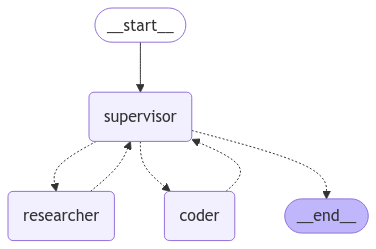

In [23]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42445?")]}, subgraphs=True
):
    print(s)
    print("----")

----------------------------------------------------------------------------------------------------
{'next': 'researcher'}
--------------------------------------------------
researcher
----------------------------------------------------------------------------------------------------
((), {'supervisor': {'next': 'researcher'}})
----
INSIDE researcher_agent NODE
{'messages': [HumanMessage(content="What's the square root of 42445?", additional_kwargs={}, response_metadata={}, id='7e51cdd8-0eb4-4f6e-84f0-0df3914af658')]}
**********
{'messages': [HumanMessage(content="What's the square root of 42445?", additional_kwargs={}, response_metadata={}, id='7e51cdd8-0eb4-4f6e-84f0-0df3914af658'), AIMessage(content='The square root of 42445 is approximately 206.01.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 88, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_t

In [26]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

----------------------------------------------------------------------------------------------------
{'next': 'researcher'}
--------------------------------------------------
researcher
----------------------------------------------------------------------------------------------------
((), {'supervisor': {'next': 'researcher'}})
----
INSIDE researcher_agent NODE
{'messages': [HumanMessage(content='Find the latest GDP of New York and California, then calculate the average', additional_kwargs={}, response_metadata={}, id='cfc550e2-c23b-47d8-b52e-13c4d2df43e9')]}
**********
(('researcher:d16ebd79-6f44-a2b2-81b0-d97a76aa2247',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DUC3JWvsTO21xzJixoUM3tGK', 'function': {'arguments': '{"query": "latest GDP of New York 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_4sLSpl5WrcN2Sko87lrBcW9J', 'function': {'arguments': '{"query": "latest GDP of California 2023"}', 'nam

In [27]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["output_formatter"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with output_formatter."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]


llm = llm


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*options]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    print("--"*50)
    print(response)
    print("-"*50)
    print(response["next"])
    print("--"*50)
    goto = response["next"]
    if goto == "output_formatter":
        goto = "output_formatter"

    return Command(goto=goto, update={"next": goto})



In [57]:
system_prompt1 = (
    """you are output formatter, giver user query and answer, give a very short answer in 10 words or less. keep it simple, give the answer in json format
    for example:
    {
        "query": "What is the GDP of California?", 
        "answer": "3.2 trillion"
    }
    """
)

def respond_node(state: MessagesState):
    print("INSIDE respond_node")
    print(state["messages"][0].content)
    print("*"*10)
    print(state["messages"][-1].content)
    print("*"*20)
    messages = [
        {"role": "system", "content": system_prompt1},
    ] + [HumanMessage(content=state["messages"][0].content)] + [HumanMessage(content=state["messages"][-1].content)]
    response = llm.invoke(messages)
    print(response.content)
    print("*"*50)
    
    return {"messages": [AIMessage(content=response.content, name="output_formatter")]}

In [58]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", web_research_node)
builder.add_node("coder", coder_node)
builder.add_node("output_formatter", respond_node)
builder.add_edge("output_formatter", END)
graph = builder.compile()

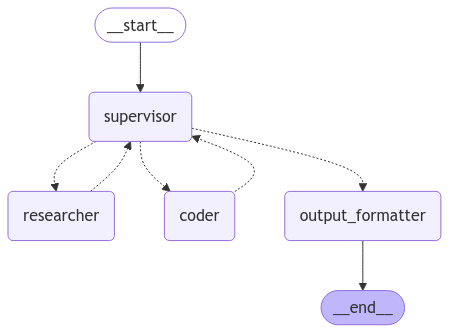

In [59]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of India and Australia, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

----------------------------------------------------------------------------------------------------
{'next': 'researcher'}
--------------------------------------------------
researcher
----------------------------------------------------------------------------------------------------
((), {'supervisor': {'next': 'researcher'}})
----
INSIDE researcher_agent NODE
{'messages': [HumanMessage(content='Find the latest GDP of India and Australia, then calculate the average', additional_kwargs={}, response_metadata={}, id='4abbbb97-34a6-4c45-9583-e65f98b20184')]}
**********
(('researcher:47146801-1cbf-be50-b0cf-6d160cf7f6b9',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ACBtNwtHJGzwCnbeGEutmf9l', 'function': {'arguments': '{"query": "latest GDP of India 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_4HMsCswFxayH5twKue9r976c', 'function': {'arguments': '{"query": "latest GDP of Australia 2023"}', 'name': 'tav

In [60]:
answer = graph.invoke(input={"messages": [("user", "Find the latest GDP of India and Australia, then calculate the average?")]})
answer

----------------------------------------------------------------------------------------------------
{'next': 'researcher'}
--------------------------------------------------
researcher
----------------------------------------------------------------------------------------------------
INSIDE researcher_agent NODE
{'messages': [HumanMessage(content='Find the latest GDP of India and Australia, then calculate the average?', additional_kwargs={}, response_metadata={}, id='fd78ca80-2dbe-4e40-8fe5-0d27845fdb79')]}
**********
{'messages': [HumanMessage(content='Find the latest GDP of India and Australia, then calculate the average?', additional_kwargs={}, response_metadata={}, id='fd78ca80-2dbe-4e40-8fe5-0d27845fdb79'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KTOpRqWXIqwnzWDenVmt5drp', 'function': {'arguments': '{"query": "latest GDP of India 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_ogCdi8iFnxEkiBe33ZW0wy75', 'function': {

{'messages': [HumanMessage(content='Find the latest GDP of India and Australia, then calculate the average?', additional_kwargs={}, response_metadata={}, id='fd78ca80-2dbe-4e40-8fe5-0d27845fdb79'),
  HumanMessage(content='The latest GDP figures for India and Australia in 2023 are as follows:\n\n- **India**: The GDP is approximately **$3,549.92 billion**.\n- **Australia**: The GDP is approximately **$1,723.83 billion**.\n\nTo calculate the average GDP:\n\n\\[\n\\text{Average GDP} = \\frac{\\text{GDP of India} + \\text{GDP of Australia}}{2} = \\frac{3549.92 + 1723.83}{2} = \\frac{5273.75}{2} = 2636.875 \\text{ billion USD}\n\\]\n\nThus, the average GDP of India and Australia is approximately **$2,636.88 billion**.', additional_kwargs={}, response_metadata={}, name='researcher', id='68732512-a442-4912-aae3-a807648962af'),
  AIMessage(content='{\n    "query": "What is the average GDP of India and Australia?",\n    "answer": "$2,636.88 billion"\n}', additional_kwargs={}, response_metadata={

In [63]:
answer.get("messages")[-1].content

'{\n    "query": "What is the average GDP of India and Australia?",\n    "answer": "$2,636.88 billion"\n}'

In [64]:
answer = graph.invoke(input={"messages": [("user", "What is suqare of 35 + 998")]})
answer

----------------------------------------------------------------------------------------------------
{'next': 'coder'}
--------------------------------------------------
coder
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
{'next': 'output_formatter'}
--------------------------------------------------
output_formatter
----------------------------------------------------------------------------------------------------
INSIDE respond_node
What is suqare of 35 + 998
**********
The square of 35 plus 998 is \( 1225 + 998 = 2223 \).
********************
{
    "query": "What is square of 35 + 998?",
    "answer": "2223"
}
**************************************************


{'messages': [HumanMessage(content='What is suqare of 35 + 998', additional_kwargs={}, response_metadata={}, id='5b75256c-8b5f-4586-b183-1014e8ca2e06'),
  HumanMessage(content='The square of 35 plus 998 is \\( 1225 + 998 = 2223 \\).', additional_kwargs={}, response_metadata={}, name='coder', id='333cb1c7-bea9-4c91-bc87-0de4b37fb6e6'),
  AIMessage(content='{\n    "query": "What is square of 35 + 998?",\n    "answer": "2223"\n}', additional_kwargs={}, response_metadata={}, name='output_formatter', id='943e2431-ee17-44c7-a9da-67e1c0e5b161')]}

In [65]:
answer.get("messages")[-1].content

'{\n    "query": "What is square of 35 + 998?",\n    "answer": "2223"\n}'

In [70]:
from langgraph.graph import Graph, StateGraph
from typing import TypedDict, Annotated, Dict
from langchain_core.messages import HumanMessage, AIMessage
from datetime import datetime
import random
import asyncio

# Define state
class AgentState(TypedDict):
    messages: list
    current_agent: str
    kpi_data: Dict[str, float]
    formatted_output: str

# KPI Agent base class with dummy data
class KPIAgent:
    def __init__(self, kpi_name: str, min_value: float, max_value: float):
        self.kpi_name = kpi_name
        self.min_value = min_value
        self.max_value = max_value
    
    async def fetch_kpi(self) -> float:
        await asyncio.sleep(0.5)
        return round(random.uniform(self.min_value, self.max_value), 2)

# Create specific KPI agents with realistic dummy data ranges
class RevenueAgent(KPIAgent):
    def __init__(self):
        super().__init__("revenue", 800000, 1200000)

class CustomerAgent(KPIAgent):
    def __init__(self):
        super().__init__("customers", 5000, 8000)

class ConversionAgent(KPIAgent):
    def __init__(self):
        super().__init__("conversion", 2.5, 5.0)

class ChurnAgent(KPIAgent):
    def __init__(self):
        super().__init__("churn", 1.0, 3.0)

class GrowthAgent(KPIAgent):
    def __init__(self):
        super().__init__("growth", 5.0, 15.0)

# Supervisor Agent
class SupervisorAgent:
    def __init__(self):
        self.agents = {
            "revenue": RevenueAgent(),
            "customers": CustomerAgent(),
            "conversion": ConversionAgent(),
            "churn": ChurnAgent(),
            "growth": GrowthAgent()
        }
    
    async def process_query(self, state: AgentState) -> AgentState:
        last_message = state["messages"][-1]
        query = last_message.content.lower()
        
        # Default to "unknown" if no matching agent is found
        state["current_agent"] = "unknown"
        
        # Try to match query to an agent
        for agent_name, agent in self.agents.items():
            if agent_name in query:
                state["current_agent"] = agent_name
                kpi_value = await agent.fetch_kpi()
                state["kpi_data"][agent_name] = kpi_value
                break
                
        return state

# Formatter Agent
class FormatterAgent:
    def format_output(self, state: AgentState) -> AgentState:
        kpi_name = state["current_agent"]
        
        # Handle case where no matching agent was found
        if kpi_name == "unknown" or kpi_name not in state["kpi_data"]:
            state["formatted_output"] = """
❌ KPI Report Error
-----------------
Could not determine which KPI to fetch from your query.
Available KPIs: revenue, customers, conversion, churn, growth

Example queries:
- "Get the revenue KPI"
- "Show me the current customer count"
- "What's our conversion rate?"
"""
            return state
            
        kpi_value = state["kpi_data"][kpi_name]
        
        # Format value based on KPI type
        if kpi_name == "revenue":
            formatted_value = f"${kpi_value:,.2f}"
        elif kpi_name == "customers":
            formatted_value = f"{int(kpi_value):,}"
        else:
            formatted_value = f"{kpi_value:.2f}%"
            
        formatted_text = f"""
📊 KPI Report
-------------
📌 Metric: {kpi_name.title()}
📈 Value: {formatted_value}
🕒 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""
        state["formatted_output"] = formatted_text
        return state

# Create the graph
def create_kpi_graph() -> Graph:
    workflow = StateGraph(AgentState)
    
    supervisor = SupervisorAgent()
    formatter = FormatterAgent()
    
    workflow.add_node("supervisor", supervisor.process_query)
    workflow.add_node("formatter", formatter.format_output)
    
    workflow.set_entry_point("supervisor")
    workflow.add_edge("supervisor", "formatter")
    workflow.set_finish_point("formatter")
    
    return workflow.compile()

# Example usage
async def run_query(query: str):
    graph = create_kpi_graph()
    
    initial_state = AgentState(
        messages=[HumanMessage(content=query)],
        current_agent="",
        kpi_data={},
        formatted_output=""
    )
    
    final_state = await graph.ainvoke(initial_state)
    print(final_state["formatted_output"])

# Run multiple queries
async def main():
    queries = [
        "Get the revenue KPI",
        "Show me the current customer count",
        "What's our conversion rate?",
        "Check the churn rate",
        "What's our growth rate?",
        "Invalid query that won't match any KPI"  # Added to test error handling
    ]
    
    for query in queries:
        print(f"\nProcessing query: '{query}'")
        print("-" * 40)
        await run_query(query)
        await asyncio.sleep(1)


if __name__ == "__main__":
    await main()


Processing query: 'Get the revenue KPI'
----------------------------------------

📊 KPI Report
-------------
📌 Metric: Revenue
📈 Value: $900,665.15
🕒 Timestamp: 2025-02-01 19:28:37


Processing query: 'Show me the current customer count'
----------------------------------------

❌ KPI Report Error
-----------------
Could not determine which KPI to fetch from your query.
Available KPIs: revenue, customers, conversion, churn, growth

Example queries:
- "Get the revenue KPI"
- "Show me the current customer count"
- "What's our conversion rate?"


Processing query: 'What's our conversion rate?'
----------------------------------------

📊 KPI Report
-------------
📌 Metric: Conversion
📈 Value: 4.98%
🕒 Timestamp: 2025-02-01 19:28:40


Processing query: 'Check the churn rate'
----------------------------------------

📊 KPI Report
-------------
📌 Metric: Churn
📈 Value: 2.81%
🕒 Timestamp: 2025-02-01 19:28:41


Processing query: 'What's our growth rate?'
----------------------------------------


In [72]:
from langgraph.graph import Graph, StateGraph
from typing import TypedDict, Annotated, Dict, List
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import Tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from datetime import datetime
import asyncio
import json

# Define state
class AgentState(TypedDict):
    messages: list
    current_agent: str
    kpi_data: Dict[str, float]
    formatted_output: str
    api_payload: Dict

# Mock API call function (replace with real API calls)
async def call_api(endpoint: str, payload: dict) -> float:
    # Simulate API delay
    await asyncio.sleep(0.5)
    # Return dummy data based on endpoint
    dummy_data = {
        "revenue": 950000.00,
        "customers": 6500,
        "conversion": 3.5,
        "churn": 2.1,
        "growth": 8.5
    }
    return dummy_data[endpoint]

# Base KPI Agent with LLM capabilities
class LLMKPIAgent:
    def __init__(self, kpi_name: str, llm, system_prompt: str):
        self.kpi_name = kpi_name
        self.llm = llm
        
        # Create API tool
        self.api_tool = Tool(
            name=f"{kpi_name}_api",
            description=f"Call API to get {kpi_name} KPI data",
            func=lambda payload: call_api(kpi_name, payload)
        )
        
        # Create prompt for payload construction
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("user", "{query}")
        ])
        
    async def construct_payload(self, query: str) -> dict:
        """Use LLM to construct API payload based on query"""
        messages = self.prompt.format_messages(query=query)
        response = await self.llm.ainvoke(messages)
        
        # Clean and parse the LLM response
        try:
            # Remove any markdown code block syntax if present
            content = response.content
            if "```json" in content:
                content = content.split("```json")[1].split("```")[0]
            elif "```" in content:
                content = content.split("```")[1].split("```")[0]
                
            # Clean up the string
            content = content.strip()
            
            # Parse JSON
            payload = json.loads(content)
            
            # Ensure all expected fields are present with default values
            default_fields = {
                "timeframe": "daily",
                "segment": "all",
                "channel": "all",
                "period": "current"
            }
            
            return {**default_fields, **payload}
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON payload: {str(e)}")
            return {
                "timeframe": "daily",
                "segment": "all",
                "channel": "all",
                "period": "current"
            }

    async def fetch_kpi(self, query: str) -> tuple[float, dict]:
        """Construct payload and fetch KPI data"""
        payload = await self.construct_payload(query)
        kpi_value = await call_api(self.kpi_name, payload)
        return kpi_value, payload

# Create specific KPI agents with specialized prompts
class RevenueAgent(LLMKPIAgent):
    def __init__(self, llm):
        system_prompt = """You are a Revenue KPI specialist. Construct API payloads for revenue queries.
        Expected payload format:
        {
            "timeframe": str,  # e.g., "daily", "monthly", "quarterly"
            "product_line": str | null,  # specific product line if mentioned
            "region": str | null  # specific region if mentioned
        }
        Extract these parameters from the user query."""
        super().__init__("revenue", llm, system_prompt)

class CustomerAgent(LLMKPIAgent):
    def __init__(self, llm):
        system_prompt = """You are a Customer Metrics specialist. Construct API payloads for customer queries.
        Expected payload format:
        {
            "segment": str | null,  # e.g., "enterprise", "smb", "consumer"
            "status": str | null,  # e.g., "active", "inactive", "all"
            "subscription_type": str | null  # e.g., "basic", "premium", "all"
        }
        Extract these parameters from the user query."""
        super().__init__("customers", llm, system_prompt)

class ConversionAgent(LLMKPIAgent):
    def __init__(self, llm):
        system_prompt = """You are a Conversion Rate specialist. Construct API payloads for conversion queries.
        Expected payload format:
        {
            "funnel_stage": str | null,  # e.g., "signup", "trial", "paid"
            "channel": str | null,  # e.g., "organic", "paid", "referral"
            "timeframe": str  # e.g., "7d", "30d", "90d"
        }
        Extract these parameters from the user query."""
        super().__init__("conversion", llm, system_prompt)

class ChurnAgent(LLMKPIAgent):
    def __init__(self, llm):
        system_prompt = """You are a Churn Analysis specialist. Construct API payloads for churn queries.
        Expected payload format:
        {
            "customer_type": str | null,  # e.g., "new", "existing", "all"
            "subscription_tier": str | null,  # e.g., "basic", "premium"
            "timeframe": str  # e.g., "30d", "90d", "annual"
        }
        Extract these parameters from the user query."""
        super().__init__("churn", llm, system_prompt)

class GrowthAgent(LLMKPIAgent):
    def __init__(self, llm):
        system_prompt = """You are a Growth Metrics specialist. Construct API payloads for growth queries.
        Expected payload format:
        {
            "metric": str,  # e.g., "revenue", "users", "mrr"
            "comparison_period": str,  # e.g., "mom", "qoq", "yoy"
            "segment": str | null  # e.g., "enterprise", "smb", null
        }
        Extract these parameters from the user query."""
        super().__init__("growth", llm, system_prompt)

# Supervisor Agent with LLM capabilities
class SupervisorAgent:
    def __init__(self):
        self.llm = ChatOpenAI(temperature=0)
        
        # Initialize all KPI agents with their specialized LLMs
        self.agents = {
            "revenue": RevenueAgent(self.llm),
            "customers": CustomerAgent(self.llm),
            "conversion": ConversionAgent(self.llm),
            "churn": ChurnAgent(self.llm),
            "growth": GrowthAgent(self.llm)
        }
        
        # Create prompt for agent selection
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """Determine which KPI agent should handle this query.
            Available agents: revenue, customers, conversion, churn, growth.
            Respond with just the agent name, or 'unknown' if no agent matches."""),
            ("user", "{query}")
        ])
    
    async def process_query(self, state: AgentState) -> AgentState:
        last_message = state["messages"][-1]
        query = last_message.content
        
        # Use LLM to determine which agent should handle the query
        messages = self.prompt.format_messages(query=query)
        response = await self.llm.ainvoke(messages)
        agent_name = response.content.strip().lower()
        
        # Clean up agent name - remove any quotes or extra whitespace
        agent_name = agent_name.replace('"', '').replace("'", '').strip()
        
        state["current_agent"] = agent_name
        state["api_payload"] = {}  # Initialize empty payload
        
        if agent_name in self.agents:
            try:
                # Get KPI value and API payload from the selected agent
                kpi_value, payload = await self.agents[agent_name].fetch_kpi(query)
                state["kpi_data"][agent_name] = kpi_value
                if isinstance(payload, dict):  # Ensure payload is a valid dict
                    state["api_payload"] = payload
            except Exception as e:
                print(f"Error processing query with {agent_name} agent: {str(e)}")
                state["current_agent"] = "unknown"
            
        return state

# Formatter Agent with LLM capabilities
class FormatterAgent:
    def __init__(self):
        self.llm = ChatOpenAI(temperature=0)
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """Format the KPI data into a clear report. Include:
            1. The KPI name and value
            2. Any relevant context from the API payload
            3. Timestamp
            Use appropriate formatting and emojis."""),
            ("user", """KPI: {kpi_name}
            Value: {kpi_value}
            Payload: {payload}""")
        ])
    
    async def format_output(self, state: AgentState) -> AgentState:
        kpi_name = state["current_agent"]
        
        if kpi_name == "unknown" or kpi_name not in state["kpi_data"]:
            state["formatted_output"] = """
❌ KPI Report Error
-----------------
Could not determine which KPI to fetch from your query.
Available KPIs: revenue, customers, conversion, churn, growth

Example queries:
- "Get the monthly revenue for the enterprise segment"
- "Show me customer count for active premium subscribers"
- "What's our conversion rate from the paid channel?"
"""
            return state
            
        kpi_value = state["kpi_data"][kpi_name]
        payload = state["api_payload"]
        
        # Use LLM to format the output
        messages = self.prompt.format_messages(
            kpi_name=kpi_name,
            kpi_value=kpi_value,
            payload=json.dumps(payload, indent=2)
        )
        response = await self.llm.ainvoke(messages)
        
        state["formatted_output"] = response.content
        return state

# Create the graph
def create_kpi_graph() -> Graph:
    workflow = StateGraph(AgentState)
    
    supervisor = SupervisorAgent()
    formatter = FormatterAgent()
    
    workflow.add_node("supervisor", supervisor.process_query)
    workflow.add_node("formatter", formatter.format_output)
    
    workflow.set_entry_point("supervisor")
    workflow.add_edge("supervisor", "formatter")
    workflow.set_finish_point("formatter")
    
    return workflow.compile()

# Example usage
async def run_query(query: str):
    graph = create_kpi_graph()
    
    initial_state = AgentState(
        messages=[HumanMessage(content=query)],
        current_agent="",
        kpi_data={},
        formatted_output="",
        api_payload={}
    )
    
    final_state = await graph.ainvoke(initial_state)
    print(final_state["formatted_output"])

# Run example queries
async def main():
    queries = [
        "What's our monthly revenue for the enterprise segment?",
        "Show me the active customer count for premium subscribers",
        "What's the conversion rate from our paid channel in the last 30 days?",
        "What's our quarterly churn rate for premium customers?",
        "Show me the month-over-month growth in enterprise segment"
    ]
    
    for query in queries:
        print(f"\nProcessing query: '{query}'")
        print("-" * 40)
        await run_query(query)
        await asyncio.sleep(1)

if __name__ == "__main__":
    await main()


Processing query: 'What's our monthly revenue for the enterprise segment?'
----------------------------------------
Error processing query with revenue agent: '\n            "timeframe"'

❌ KPI Report Error
-----------------
Could not determine which KPI to fetch from your query.
Available KPIs: revenue, customers, conversion, churn, growth

Example queries:
- "Get the monthly revenue for the enterprise segment"
- "Show me customer count for active premium subscribers"
- "What's our conversion rate from the paid channel?"


Processing query: 'Show me the active customer count for premium subscribers'
----------------------------------------
Error processing query with customers agent: '\n            "segment"'

❌ KPI Report Error
-----------------
Could not determine which KPI to fetch from your query.
Available KPIs: revenue, customers, conversion, churn, growth

Example queries:
- "Get the monthly revenue for the enterprise segment"
- "Show me customer count for active premium subsc